<a href="https://colab.research.google.com/github/ssharifazari/Baseflow-project/blob/main/AutoVL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AutoVL**
A Python script to apply AutoVL (Automated Variable Leak) developed by Vincent Lyne (2025).

Citation:

Vincent Lyne. "AutoVL: Automated streamflow separation for changing catchments and climate impact analysis." Journal of Hydrology X 26 (2025): 100195
https://doi.org/10.1016/j.hydroa.2024.100195

## **Create required functions**
This section creates required functions to apply AutoVL algorithm and an additional one for plotting:

initial_alph(y) calculates an initial value for `alpha` from the given discharge `y`. The initial `alpha` is calculated as follows:
 1. Prepare the values of `Q` to build a linear model in the form of y_t = alpha * y_(t-1).
 2. Fit the linear model to obtain the value of alpha and return it as an alpha_initial.

VL_splitter(y, alpha) calculates the fastflow `f_t` and baseflow `b_t` component from the given discharge `y` and parameter `alpha`

 The calculation is as follows:
 1. Set the initial value for f to start: f_1 = y_1
 2. Calculate fastflow components: f_t = alpha*f_t_1 + (y_t - y_t_1)
 3. Check if the calculate f_t is smaller than y_t
 4. Calculate the baseflow component: b_t = y_t - f_t
 5. Check if the calculated b_t is smaller than y_t
 6. Check if all flow components are positive

 baseflow_decay(y, f, b) calculates the values of `alpha_f`, `alpha_b`, and `beta` from the given discharge `y`, fastflow `f`, and baseflow `b` series based on the baseflow decay model

1. Obtain the value of `alpha_f` from fitting a linear model in the form of: f_t = alpha_f*f_t_1 + (y_t - y_t_1)
2. Obtain values of `alpha_b` and `beta` from fitting a linear model in the form of: b_t = alpha_b*b_t_1 + alpha_f*f_t_1
3. Set `alpha` as the maximum value between `alpha_f` and `alpha_b` to be used in the VL_splitter in the next step


In [6]:
def initial_alph(y):
    """
    Args:
        y (numpy.ndarray): Array of discharge values.

    Returns:
        float: The calculated recession coefficient.
    """
    y = y[0]
    y_t, y_t_1 = y[1:], y[:-1]
    y_pos = list()
    for t in range(len(y_t)):
        if y_t_1[t] >= y_t[t]:
            y_pos.append(t)

    # LinReg = np.polyfit(y_t_1[q_pos], y_t[q_pos], 1)
    LinReg = sm.OLS(y_t[y_pos], y_t_1[y_pos])
    alpha_init = LinReg.fit().params[0]

    return alpha_init

def VL_splitter(y, alpha):
    """
    Args:
        Q (numpy.ndarray): Array of discharge values.
        alpha (numpy.ndarray)

    Returns:
        f (numpy.ndarray): The calculated fastflow component.
        b (numpy.ndarray): The calculated baseflow component.
    """
    y = y[0]
    f = list()
    f.append(y[0])
    b = [0]
    for t in range(1, len(y)):

        f.append((alpha*f[t-1] + (y[t] - y[t-1])).item())
        if f[t] > y[t]:
            f[t] = y[t]
        elif f[t] < 0:
            f[t] = 0

        b.append((y[t] - f[t]).item())
        if b[t] > y[t]:
            b[t] = y[t]
    return f, b

def baseflow_decay(y, f, b):
    """
    Args:
        y (numpy.ndarray): Array of discharge values.
        f (numpy.ndarray): list of discharge values.
        b (numpy.ndarray): list of discharge values.

    Returns:
        alpha_f (numpy.ndarray): float.
        alpha_f (numpy.ndarray): float.
        betha (numpy.ndarray): float.
        alpha (numpy.ndarray): float.

    """
    y = y[0]
    y_t, y_t_1 = y[1:], y[:-1]
    f_t, f_t_1 = f[1:], f[:-1]
    b_t, b_t_1 = b[1:], b[:-1]

    Y = f_t - (y_t - y_t_1)
    LinReg = sm.OLS(Y, f_t_1)
    alpha_f = LinReg.fit().params[0]

    X = np.column_stack((b_t_1, f_t_1))
    LinReg = sm.OLS(b_t, X)
    alpha_b = LinReg.fit().params[0]
    beta = LinReg.fit().params[1]

    return alpha_f, alpha_b, beta

# Visualization function
def plot_baseflow_separation(Q, baseflows, method_names=None, interactive=False):
    if method_names is None:
        method_names = list(baseflows.keys())

    if interactive:
        fig = make_subplots()
        fig.add_trace(go.Scatter(x=Q.index, y=Q.values, name='Streamflow', line=dict(width=2)))

        for method in method_names:
            if method in baseflows:
                fig.add_trace(go.Scatter(x=Q.index, y=baseflows[method], name=f'{method} Baseflow'))

        fig.update_layout(
            title='Baseflow Separation',
            xaxis_title='Date',
            yaxis_title='Flow',
            legend_title='Methods',
            hovermode="x unified",
            width=1100,
            height=600
        )

        return fig
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(Q.index, Q.values, label='Observed Streamflow', alpha=0.7)

        for method in method_names:
            if method in baseflows:
                plt.plot(Q.index, baseflows[method], label=f'{method} Baseflow', alpha=0.7)

        plt.xlabel('Date')
        plt.ylabel('Flow')
        plt.title('Baseflow Separation')
        plt.legend()
        plt.grid(True)

        return plt.gcf()

## **Install and import relevant packages**
baseflow is a Python package that allows baseflow separation using a number of graphical and digital filter methods. This package offers a wide range of tools and techniques for streamflow data analysis, with detailed explanation is given in: https://baseflow.readthedocs.io/en/latest/
    
Citation:

Xie, J., Liu, X., Jasechko, S., Berghuijs, W. R., Wang, K., Liu, C., Reichstein, M., Jung, M., & Koirala, S. (2024). Majority of global river flow sustained by groundwater. Nature Geoscience, 17(8), 770–777. https://doi.org/10.1038/s41561-024-01483-5

Xie, J., Liu, X., Wang, K., Yang, T., Liang, K., & Liu, C. (2020). Evaluation of typical methods for baseflow separation in the contiguous United States. Journal of Hydrology, 583, 124628. https://doi.org/10.1016/j.jhydrol.2020.124628

In [ ]:
%pip install baseflow%pip install statsmodels

In [ ]:
import matplotlib.pyplot as plt
import  os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import baseflow

# **Load and clean example Q data**
This code loads example streamflow data (Q). Daily streamflow data including, the example data provided by the baseflow library, flow records for Cockburn catchment (NSW419016; 2006-2012), and Harvy River at dingo road (WA613002; 1970-2023) are given in three separate CSV files. The data cleaning function used here from baseflow package facilitates the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset.

Here are the steps involved:


*   Identify Errors: Examine the dataset for issues like missing values, outliers, inconsistencies, or incorrect formatting.
*   Handle Missing Data: drop the NaN values
*   Standardize Formatting: Ensure consistent formatting across the dataset for dates, numbers, text, etc.
*   Check data quality: only keep the data of more than 120 days/year record

Other CSV file in the correct format can also be uploaded to the example data folder.

In [ ]:
# CSV file for provided by baseflow package
#df = pd.read_csv(baseflow.example, index_col=0, parse_dates=True)

# CSV file for Cockburn River at Mulla Crossing, NSW, station: 419016
#df = pd.read_csv('example data/Hydstra_419016_151.csv', index_col = 0, parse_dates = True, dayfirst = True)

# CSV file for Harvy River at Dingo Road, WA, BOM station: 613002. If you reproduce Vincent Lyne (2025)'s results
df = pd.read_csv('example data/HarvyRiver_613002.csv', index_col = 0, parse_dates = True, dayfirst = True)

Q = df[df.columns[0]]
#df_1973 = df.loc['1973']
#Q = df[df_1973.columns[0]]
Q

Date
1970-03-20    7.1712
1970-03-21    6.3072
1970-03-22    5.5296
1970-03-23    4.9248
1970-03-24    4.5792
               ...  
2023-12-27    0.0000
2023-12-28    0.0000
2023-12-29    0.0000
2023-12-30    0.0000
2023-12-31    0.0000
Name: WA_HR_613002, Length: 19645, dtype: float64

In [ ]:
import baseflow.utils
Q = baseflow.utils.clean_streamflow(Q)

# **Baseflow separation**
In this part AutoVal algorithm and other digital filter methods will first be applied to the loaded time series

## **AutoVL method**
To start the algorithm an initial value will be estimated for `alpha` and empty lists will be allocated to fastflow and baseflow comonents. The while loop will then be repeated to satisfy the threshold sepcified for the difference between two subsequent `alpha` values

In [ ]:
def extract_years_data(Q, years):
    # Get the indices where the year matches any in the list of years

    if isinstance(years, int):
            years = [years]

    indices = [i for i in range(len(Q[1])) if Q[1][i].year in years]

    # Use the indices to filter both values and dates
    values_for_years = Q[0][indices]
    dates_for_years = Q[1][indices]

    # Return the filtered data as a tuple
    return (values_for_years, dates_for_years)

In [ ]:
def AutVL(q, alpha, delta_alpha, year):

   Alpha_tmp = []
   Alpha_f_tmp = []
   Alpha_b_tmp = []
   Beta_tmp = []
   params = dict()
   while True:
       # run the VL splitter to obtain f and b
       f, b = VL_splitter(q, alpha)

       # run the baseflow decay model
       alpha_f, alpha_b, beta = baseflow_decay(q, f, b)

       # set `alpha` as the maximum value between `alpha_f` and `alpha_b`
       alpha_new = max([alpha_f, alpha_b])
       delta_alpha_tmp = abs(alpha_new - alpha)
       alpha = alpha_new

       # store the parameters in the pre-allocated lists
       Alpha_tmp.append(alpha)
       Alpha_f_tmp.append(alpha_f)
       Alpha_b_tmp.append(alpha_b)
       Beta_tmp.append(beta)

       if delta_alpha_tmp < delta_alpha:
           break

   params = {
       "Alpha": {"values": Alpha_tmp},
       "Alpha_f" : {"values": Alpha_f_tmp},
       "Alpha_b" : {"values": Alpha_b_tmp},
       "Beta" : {"values": Beta_tmp}
       }
   bf_AutoVL = {'AutoVL': b}
   return params, bf_AutoVL


In [ ]:
# Initialization for AutoVL method
dates = Q[1]
delta_alpha = 1e-4
uniqe_years = dates.year.unique()

# Define the length of the moving window
window_size = 1

# Pre-allocate a dictionary to the resulted baseflows
baseflows = dict()

## **Comparsion between methods**
Baseflow series from different methods, including AutoVL, will be calculated from the original series in this section.

In [ ]:
# Loop through the data to obtain baseflows
param_AutoVL = {}
for year in uniqe_years:

    # extract subset of the data
    q = extract_years_data(Q, year)
    alpha = initial_alph(q)

    # AutoVL
    params, bf_AutoVL = AutVL(q, alpha, delta_alpha, year)

    # Apply methods from baseflow Python package. This includes original Lyne & Holick (1979),
    #  Chapman (1991), Furey and Gupta (2000), Eckhardt (2005), and EWMA methods.
    # Extract flow values from q to be used in baseflow package
    q_values, _ = q

    # Lyne-Holick 1979
    bf_lh = {'Lyne Hollick': baseflow.lh(q_values,beta=0.925, return_exceed=False), }

    # Champan 1991
    a = 0.98  # Assumed recession coefficient
    bf_chapman = {'Chapman': baseflow.chapman(q_values, a, initial_method='Q0',return_exceed=False),}

    # Furey and Gupta 2001
    A = 0.1 # Assumed parameter A
    bf_furey = {'Furey': baseflow.furey(q_values,a, A, initial_method='Q0', return_exceed=False),}

    # Eckhardt 2005
    BFImax = 0.8  # Assumed parameter BFImax
    bf_eckhardt = {'Eckhardt': baseflow.eckhardt(q_values, a, BFImax, initial_method='Q0', return_exceed=False),}

    # EMWA 2008
    e = 0.2  # Assumed parameter e
    bf_ewma = {'EWMA': baseflow.ewma(q_values, e, initial_method='Q0', return_exceed=False),}

    baseflows[year] = {'Lyne Hollick': bf_lh['Lyne Hollick'],
               'Chapman': bf_chapman['Chapman'],
               'Eckhardt': bf_eckhardt['Eckhardt'],
               'EWMA': bf_ewma['EWMA'],
               'Furey': bf_furey['Furey'],
               'AutoVL': bf_AutoVL['AutoVL'],
               }
    param_AutoVL[year] = params



## **Visualization**
In this part the resulted baseflow from different methods will be plotted against ech other for the desired year. The convergence of AutoVL parameters will be also plotted in a separate figure.

In [ ]:
# Plotting
year = int(input("Enter the year of interest for plotting: {year}"))
q = extract_years_data(Q, year)
qq = pd.Series(data=q[0], index=q[1], name = df.columns[0])
fig = plot_baseflow_separation(qq, baseflows[year], ['Lyne Hollick', 'Chapman', 'Eckhardt', 'EWMA', 'Furey', 'AutoVL'], interactive = True)
fig.show()

Text(0, 0.5, 'Coefficient')

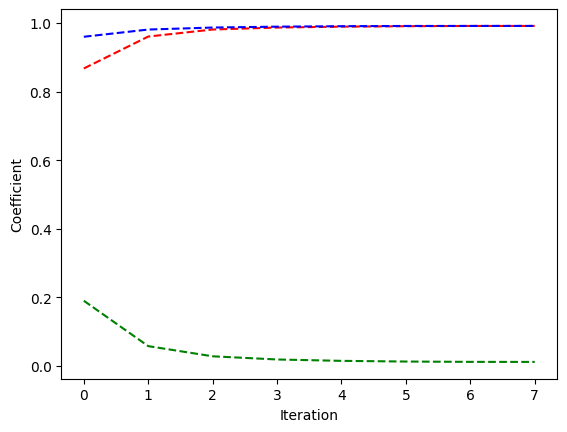

In [ ]:
# AutoVL parameter convergence
Alpha = [float(i) for i in param_AutoVL[year]['Alpha']['values']]
Alpha_f = [float(i) for i in param_AutoVL[year]['Alpha_f']['values']]
Alpha_b = [float(i) for i in param_AutoVL[year]['Alpha_b']['values']]
Beta = [float(i) for i in param_AutoVL[year]['Beta']['values']]
itr = list(range(0, len(Alpha)))

plt.plot(itr, Alpha_f, 'r--', itr, Alpha_b, 'b--', itr, Beta, 'g--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient')

## **Climate impact on AutoVL parameters**
The impact of climate will be evaluated by plotting the obtained value for each parameter in different years

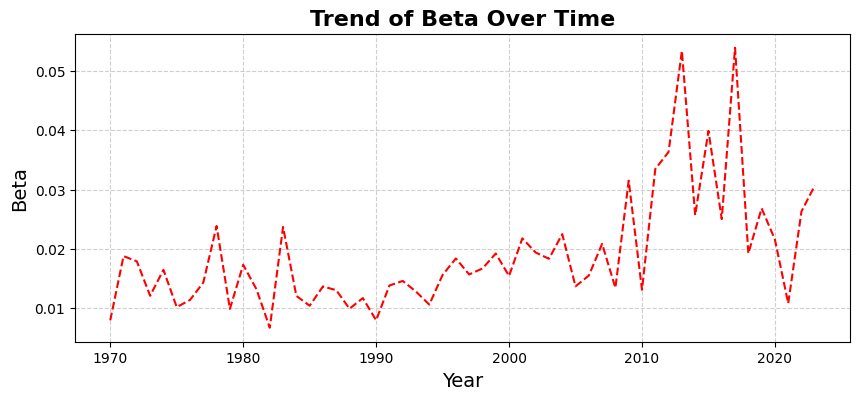

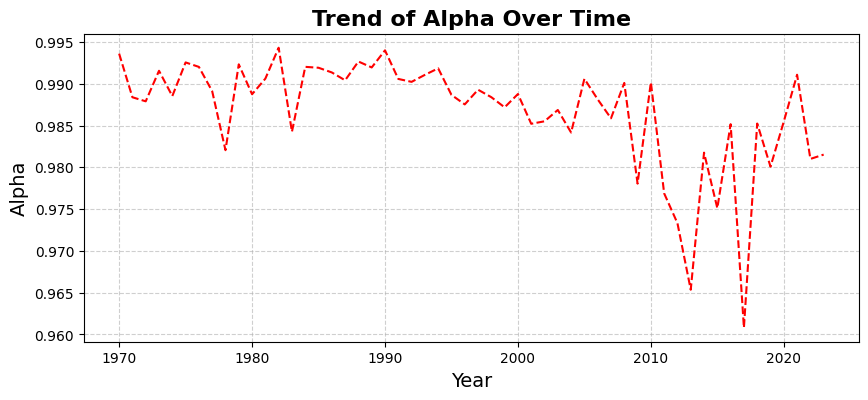

In [ ]:
ALPHA = [param_AutoVL[year]['Alpha']['values'][-1] for year in uniqe_years]
ALPHA_f = [param_AutoVL[year]['Alpha_f']['values'][-1] for year in uniqe_years]
ALPHA_b = [param_AutoVL[year]['Alpha_b']['values'][-1] for year in uniqe_years]
BETA = [param_AutoVL[year]['Beta']['values'][-1] for year in uniqe_years]

plt.figure(figsize=(10, 4))  # Set figure size for better readability
plt.plot(uniqe_years, BETA, 'r--', label='Beta')
plt.title('Trend of Beta Over Time', fontsize=16, fontweight='bold')
#plt.ylim(0, 0.06)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Beta', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(10, 4))  # Set figure size for better readability
plt.plot(uniqe_years, ALPHA, 'r--', label='Alpha')
plt.title('Trend of Alpha Over Time', fontsize=16, fontweight='bold')
#plt.ylim(0.95, 1)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Alpha', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
